## Setup

In [1]:
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

In [2]:
import logging
import time

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Data Handling

## Downloading the data

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteFGUE6I/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteFGUE6I/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteFGUE6I/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


## Importing the custom tokenizer

In [4]:
model_path = '/kaggle/input/bert-subword-tokenizer/bert_subword_tokenizer_pt_en_converter'
tokenizers = tf.saved_model.load(model_path)

In [5]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

...................................................

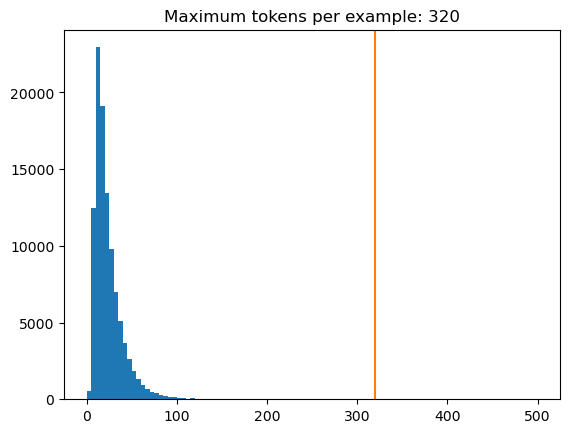

In [6]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())
    
    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end = '', flush = True)
    
    
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

# Set up a data pipeline

In [7]:
MAX_TOKENS = 128

def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt) # output is ragged
    pt = pt[:, :MAX_TOKENS] #trim to max_tokens
    pt = pt.to_tensor() # convert to 0-padded dense tensor
    
    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS + 1)]
    en_inputs = en[:, :-1].to_tensor() # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()  # Drop the [START] tokens
    
    return (pt, en_inputs), en_labels

In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [9]:
def make_batches(ds):
    return(
        ds
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size = tf.data.AUTOTUNE)
    )

In [10]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [11]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)
print(en[0][:10])
print(en_labels[0][:10])

(64, 79)
(64, 87)
(64, 87)
tf.Tensor([  2 217  27 101 169  13  82 186   9  55], shape=(10,), dtype=int64)
tf.Tensor([217  27 101 169  13  82 186   9  55 164], shape=(10,), dtype=int64)


# Positional Encoding

In [12]:
# Instead of interleaving the sines and cosines, the vectors of sines and cosines are simply concatenated.

def positional_encoding(length, depth):
    depth = depth / 2
    
    positions = np.arange(length)[:, np.newaxis] # (pos, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth # (1, depth)
    
    angle_rates = 1 / (10000 ** depths) # (1, depth)
    angle_rads = positions * angle_rates # (pos, depth)
    
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis = -1
    )
    return tf.cast(pos_encoding, dtype = tf.float32)
    

(2048, 512)


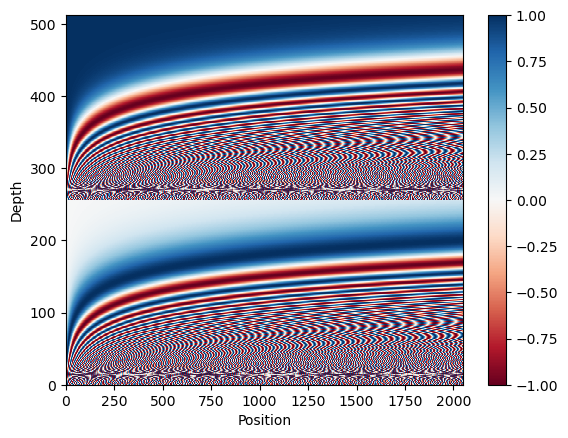

In [13]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

 Below the position encoding vectors are normalized and the vector from position 1000 is compared, by dot-product, to all the others:



(0.0, 1.0)

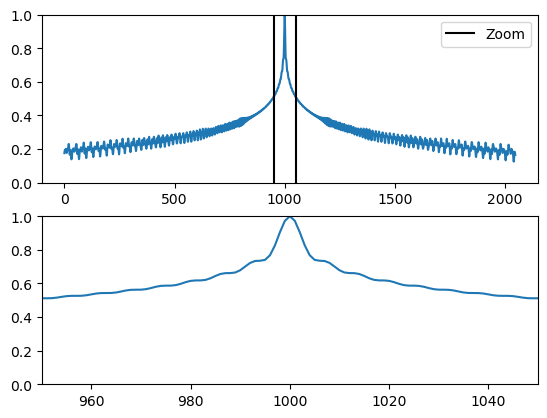

In [14]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [15]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_encoding = positional_encoding(length = 2048, depth = d_model)
    
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    
    def call(self, x):
        length = tf.shape(x)[1]  # 0 is batch dimension
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x
        

In [16]:
embed_pt = PositionalEmbedding(vocab_size = tokenizers.pt.get_vocab_size(), d_model = 512)
embed_en = PositionalEmbedding(vocab_size = tokenizers.en.get_vocab_size(), d_model = 512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [17]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 87), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

# Base Attention Class
Start with a simple base class that just contains the component layers. Each attention use-case will be implemented as a subclass.

In [18]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

## Cross Attention Layer
At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder.

In [19]:
 class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query = x,
            key = context,
            value = context,
            return_attention_scores = True
        )
        
        self.last_attn_scores = attn_scores # Cache the attention scores for plotting later.
        
        x = self.add([attn_output, x])
        x = self.layernorm(x)
        return x

In [20]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 79, 512)
(64, 87, 512)
(64, 87, 512)


The output length is the length of the query sequence, and not the length of the context key/value sequence.

## Global Self Attention Layer

The global self attention layer lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel.


In [21]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query = x,
            value = x,
            key = x
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [22]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 79, 512)
(64, 79, 512)


## The causal self attention layer
This layer does a similar job as the global self attention layer, for the output sequence. The causal mask ensures that each location only has access to the locations that come before it

In [23]:
class CausalSelfAttention(BaseAttention):
      def call(self, x):
        attn_output = self.mha(
            query = x,
            value = x,
            key = x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [24]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)


(64, 87, 512)
(64, 87, 512)


In [25]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

In [26]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 87, 512)
(64, 87, 512)


# Encoder Layer

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
      def __init__(self,*, d_model, num_heads, dff, dropout_rate = 0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads = num_heads,
            key_dim = d_model,
            dropout = dropout_rate
        )

        self.ffn = FeedForward(d_model, dff)

      def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x


In [28]:
sample_encoder_layer = EncoderLayer(d_model = 512, num_heads = 8, dff = 2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 79, 512)
(64, 79, 512)


# Encoder

In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.pos_embedding = PositionalEmbedding(
            vocab_size = vocab_size, d_model = d_model
        )
        
        self.enc_layers = [
            EncoderLayer(
                d_model = d_model,
                num_heads = num_heads,
                dff = dff,
                dropout_rate = dropout_rate
            )
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x):
         # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x) # Shape `(batch_size, seq_len, d_model)`.
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
            
        return x # Shape `(batch_size, seq_len, d_model)`.

In [30]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 79)
(64, 79, 512)


# Decoder Layer

In [31]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate = 0.1):
        super().__init__()
        
        self.causal_self_attention = CausalSelfAttention(
            num_heads = num_heads,
            key_dim = d_model,
            dropout = dropout_rate
        )
        
        self.cross_attention = CrossAttention(
            num_heads = num_heads,
             key_dim = d_model,
            dropout = dropout_rate
        )
        
        self.ffn = FeedForward(d_model, dff)
        
    def call(self, x, context):
        x = self.causal_self_attention(x = x)
        x = self.cross_attention(x = x, context = context)
        
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores
        
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        
        return x

In [32]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 87, 512)
(64, 79, 512)
(64, 87, 512)


# Decoder

In [33]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, * , num_layers, d_model, num_heads, dff, vocab_size, dropout_rate = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.pos_embedding = PositionalEmbedding(
            vocab_size = vocab_size,
            d_model = d_model
        )
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.dec_layers = [
            DecoderLayer(
                d_model = d_model,
                num_heads = num_heads, 
                dff = dff,
                dropout_rate = dropout_rate
            )
            for _ in range(num_layers)
        ]
        
        self.last_attn_scores = None
        
    def call(self, x, context):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)
            
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        
        return x

In [34]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 87)
(64, 79, 512)
(64, 87, 512)


In [35]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 87, 79])

# Final Transformer

In [36]:
class Transformer(tf.keras.Model):
    def __init__(self, * , num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate = 0.1):
        super().__init__()
        
        self.encoder = Encoder(
            num_layers = num_layers, 
            d_model = d_model,
            num_heads = num_heads,
            dff = dff,
            vocab_size = input_vocab_size,
            dropout_rate = dropout_rate
        )
        
        self.decoder = Decoder(
            num_layers = num_layers, 
            d_model = d_model,
            num_heads = num_heads,
            dff = dff,
            vocab_size = target_vocab_size,
            dropout_rate = dropout_rate
        )
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inputs):
        context, x = inputs
        
        context = self.encoder(context)
        
        x = self.decoder(x, context)
        
        logits = self.final_layer(x)
        
        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass
        
        return logits

# Hyperparameters

In [37]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [38]:
transformer = Transformer(
    num_layers = num_layers,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    input_vocab_size = tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size = tokenizers.en.get_vocab_size().numpy(),
    dropout_rate = dropout_rate)

output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 87)
(64, 79)
(64, 87, 7010)


In [39]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 87, 79)


In [40]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


# Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer paper.

In [41]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super().__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [42]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

Text(0.5, 0, 'Train Step')

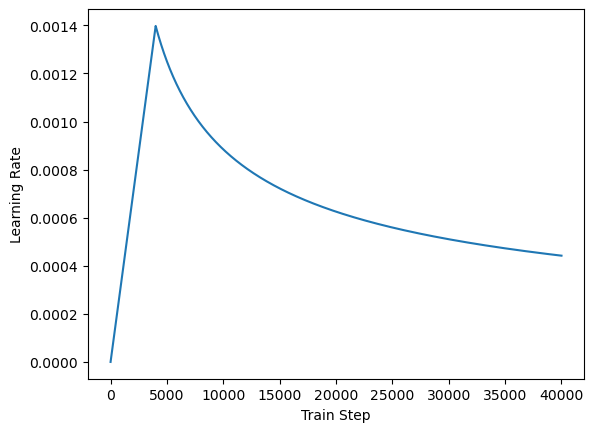

In [43]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

# Set up the loss and metrics


Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [44]:
def masked_loss(label, pred):
    mask = (label != 0)
    
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits = True,
        reduction = 'none'
    )
    
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype = loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis = 2)
        
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype = tf.float32)
    mask = tf.cast(mask, dtype = tf.float32)
    
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [45]:
print(tf.test.gpu_device_name())

/device:GPU:0


# Train the model


In [46]:
transformer.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])

transformer.fit(train_batches, epochs = 20, validation_data = val_batches)

Epoch 1/20
810/810 [==============================] - 247s 261ms/step - loss: 6.5863 - masked_accuracy: 0.1434 - val_loss: 5.0392 - val_masked_accuracy: 0.2506
Epoch 2/20
810/810 [==============================] - 155s 191ms/step - loss: 4.5624 - masked_accuracy: 0.2993 - val_loss: 4.0627 - val_masked_accuracy: 0.3552
Epoch 3/20
810/810 [==============================] - 149s 183ms/step - loss: 3.8099 - masked_accuracy: 0.3820 - val_loss: 3.4446 - val_masked_accuracy: 0.4345
Epoch 4/20
810/810 [==============================] - 147s 181ms/step - loss: 3.2706 - masked_accuracy: 0.4407 - val_loss: 2.9665 - val_masked_accuracy: 0.4918
Epoch 5/20
810/810 [==============================] - 146s 179ms/step - loss: 2.8805 - masked_accuracy: 0.4853 - val_loss: 2.7579 - val_masked_accuracy: 0.5175
Epoch 6/20
810/810 [==============================] - 147s 181ms/step - loss: 2.5616 - masked_accuracy: 0.5243 - val_loss: 2.4906 - val_masked_accuracy: 0.5552
Epoch 7/20
810/810 [====================

# Inference

In [47]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [48]:
translator = Translator(tokenizers, transformer)

In [49]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [50]:
#example 1
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem we have to address .
Ground truth   : this is a problem we have to solve .


In [51]:
#example 2
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [52]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to then very quickly share with you some stories of some magicians that happen .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


# Attention Plots

In [53]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [54]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [55]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [56]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
print(in_tokens)
print(translated_tokens)

tf.Tensor(
[b'[START]' b'este' b'e' b'o' b'primeiro' b'livro' b'que' b'eu' b'fiz'
 b'.' b'[END]'], shape=(11,), dtype=string)
tf.Tensor(
[b'[START]' b'this' b'is' b'the' b'first' b'book' b'i' b'did' b'.'
 b'[END]'], shape=(10,), dtype=string)


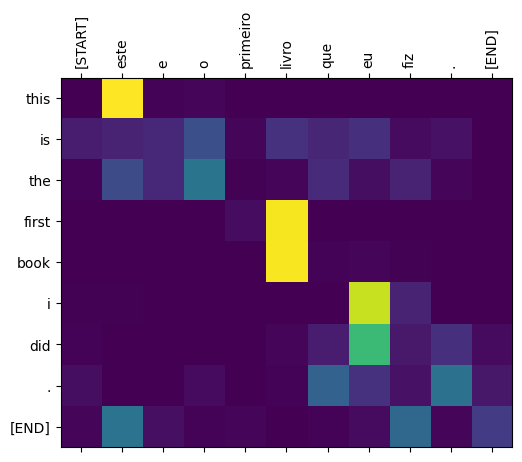

In [57]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [58]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

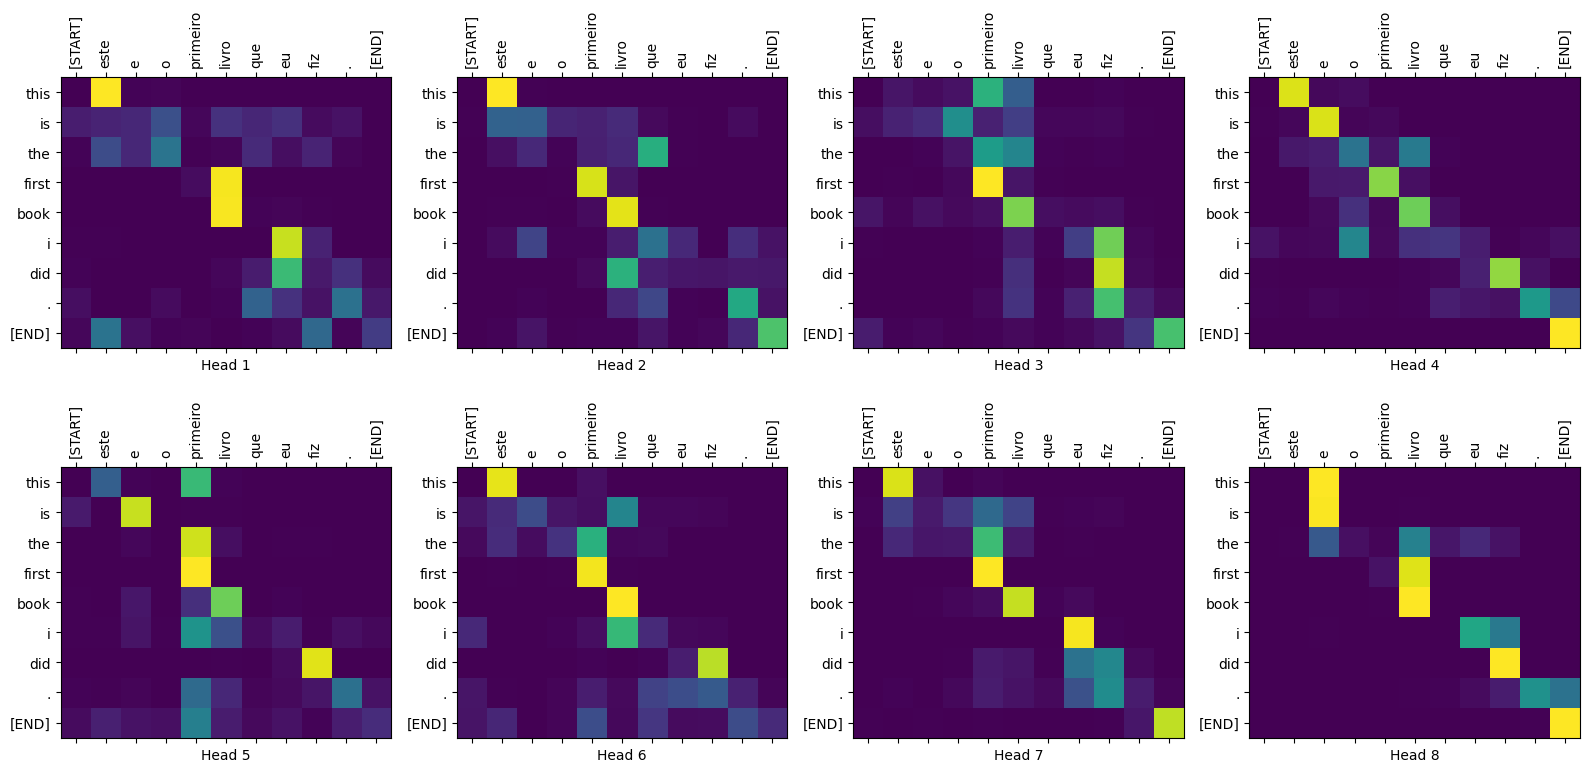

In [59]:
plot_attention_weights(sentence,translated_tokens, attention_weights[0])

# Exporting the model

In [60]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [61]:
translator = ExportTranslator(translator)

In [62]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [63]:
tf.saved_model.save(translator, export_dir='pt_en_translator')

In [64]:
!zip -r file.zip '/kaggle/working/pt_en_translator'

  adding: kaggle/working/pt_en_translator/ (stored 0%)
  adding: kaggle/working/pt_en_translator/saved_model.pb (deflated 77%)
  adding: kaggle/working/pt_en_translator/assets/ (stored 0%)
  adding: kaggle/working/pt_en_translator/assets/pt_vocab.txt (deflated 57%)
  adding: kaggle/working/pt_en_translator/assets/en_vocab.txt (deflated 54%)
  adding: kaggle/working/pt_en_translator/variables/ (stored 0%)
  adding: kaggle/working/pt_en_translator/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/pt_en_translator/variables/variables.index (deflated 79%)
  adding: kaggle/working/pt_en_translator/fingerprint.pb (stored 0%)


In [65]:
!du -h *.zip

111M	file.zip


# Reloaded Model

In [66]:
reloaded_model = tf.saved_model.load('/kaggle/input/pt-en-translator/pt_en_translator')

In [67]:
reloaded_model('ste é o primeiro livro que eu fiz.').numpy()

b'ste and the first book i did .'